In [ ]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Import tools from scikit-learn for preprocessing, dimensionality reduction, and clustering
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics

# Import visualization tools
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# Set up warnings handling to ignore warnings if not enabled
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
#Loading the dataset
dataset = pd.read_csv("/content/marketing_campaign (1).csv", sep="\t")
print("Total number of records:", len(dataset))
dataset.head()

Total number of records: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [ ]:
#Information on features
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [ ]:
# Remove rows with missing values
dataset = dataset.dropna()

# Display the number of records after dropping rows with missing values
print("Number of records after removing rows with missing data:", len(dataset))

Number of records after removing rows with missing data: 2216


In [ ]:
# Convert 'Dt_Customer' column to datetime format
dataset["Dt_Customer"] = pd.to_datetime(dataset["Dt_Customer"], format="%d-%m-%Y")

# Extract just the date from the 'Dt_Customer' column and store it in a list
enrollment_dates = [entry.date() for entry in dataset["Dt_Customer"]]

# Display the most recent and the oldest customer enrollment dates
print("Most recent customer enrollment date:", max(enrollment_dates))
print("Earliest customer enrollment date:", min(enrollment_dates))


Most recent customer enrollment date: 2014-06-29
Earliest customer enrollment date: 2012-07-30


In [ ]:
# Create a new feature "Customer_For" representing the number of days since enrollment

# Get the most recent customer's enrollment date
latest_date = max(enrollment_dates)

# Calculate the number of days each customer has been with the company
days_with_company = [(latest_date - date).days for date in enrollment_dates]

# Add the "Customer_For" feature to the dataset
dataset["Customer_For"] = days_with_company

# Ensure the new column is numeric, coercing any errors
dataset["Customer_For"] = pd.to_numeric(dataset["Customer_For"], errors="coerce")


In [ ]:
# Display the count of each category in the 'Marital_Status' feature
print("Categories in 'Marital_Status' and their counts:\n", dataset["Marital_Status"].value_counts(), "\n")

# Display the count of each category in the 'Education' feature
print("Categories in 'Education' and their counts:\n", dataset["Education"].value_counts())


Categories in 'Marital_Status' and their counts:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Categories in 'Education' and their counts:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In [ ]:
# Feature Engineering

# Calculate the current age of the customer
dataset["Age"] = 2021 - dataset["Year_Birth"]

# Compute total spendings across different product categories
dataset["Spent"] = dataset["MntWines"] + dataset["MntFruits"] + dataset["MntMeatProducts"] + dataset["MntFishProducts"] + dataset["MntSweetProducts"] + dataset["MntGoldProds"]

# Derive living situation based on marital status
dataset["Living_With"] = dataset["Marital_Status"].replace({
    "Married": "Partner", "Together": "Partner", "Absurd": "Alone", "Widow": "Alone",
    "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone"
})

# Calculate total children in the household
dataset["Children"] = dataset["Kidhome"] + dataset["Teenhome"]

# Calculate total household size
dataset["Family_Size"] = dataset["Living_With"].replace({"Alone": 1, "Partner": 2}) + dataset["Children"]

# Create a feature indicating if the customer is a parent
dataset["Is_Parent"] = np.where(dataset["Children"] > 0, 1, 0)

# Group education levels into broader categories
dataset["Education"] = dataset["Education"].replace({
    "Basic": "Undergraduate", "2n Cycle": "Undergraduate",
    "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"
})

# Rename product spending columns for clarity
dataset = dataset.rename(columns={
    "MntWines": "Wines", "MntFruits": "Fruits", "MntMeatProducts": "Meat",
    "MntFishProducts": "Fish", "MntSweetProducts": "Sweets", "MntGoldProds": "Gold"
})

# Drop redundant columns
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
dataset = dataset.drop(to_drop, axis=1)


In [ ]:
dataset.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,353.521209,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,202.434667,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,180.000000,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,355.500000,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,529.000000,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,699.000000,128.000000,2525.000000,3.000000,5.000000,1.000000


Simplified Comparative Plot of Selected Features


<Figure size 800x550 with 0 Axes>

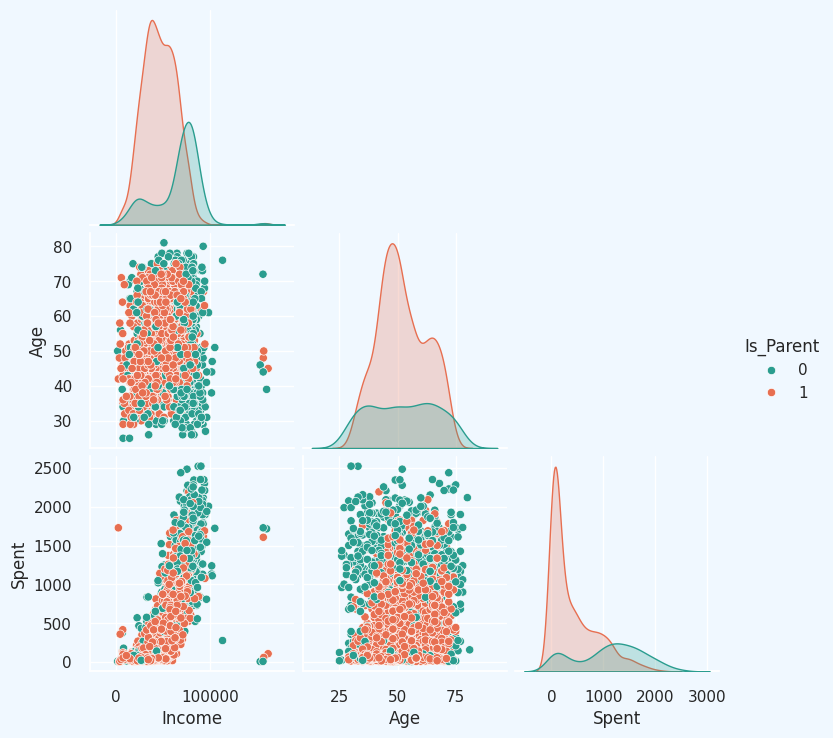

In [ ]:
# Set color preferences for the plot background
sns.set(rc={"axes.facecolor": "#F0F8FF", "figure.facecolor": "#F0F8FF"})

# Define a simpler color palette
color_palette = ["#2A9D8F", "#E76F51"]  # Two contrasting colors for clarity

# Select a smaller subset of important features to plot
features_to_plot = ["Income", "Age", "Spent", "Is_Parent"]

print("Simplified Comparative Plot of Selected Features")

# Create a pairplot for the selected features, using 'Is_Parent' for color differentiation
plt.figure()
sns.pairplot(dataset[features_to_plot], hue="Is_Parent", palette=color_palette, diag_kind="kde", corner=True)

# Show the plot
plt.show()

In [ ]:
# Remove outliers by capping 'Age' and 'Income' values

# Filter out rows where 'Age' exceeds 90
dataset = dataset[dataset["Age"] < 90]

# Filter out rows where 'Income' exceeds 600,000
dataset = dataset[dataset["Income"] < 600000]

# Display the total number of records after removing outliers
print("Total number of records after outlier removal:", len(dataset))


Total number of records after outlier removal: 2212


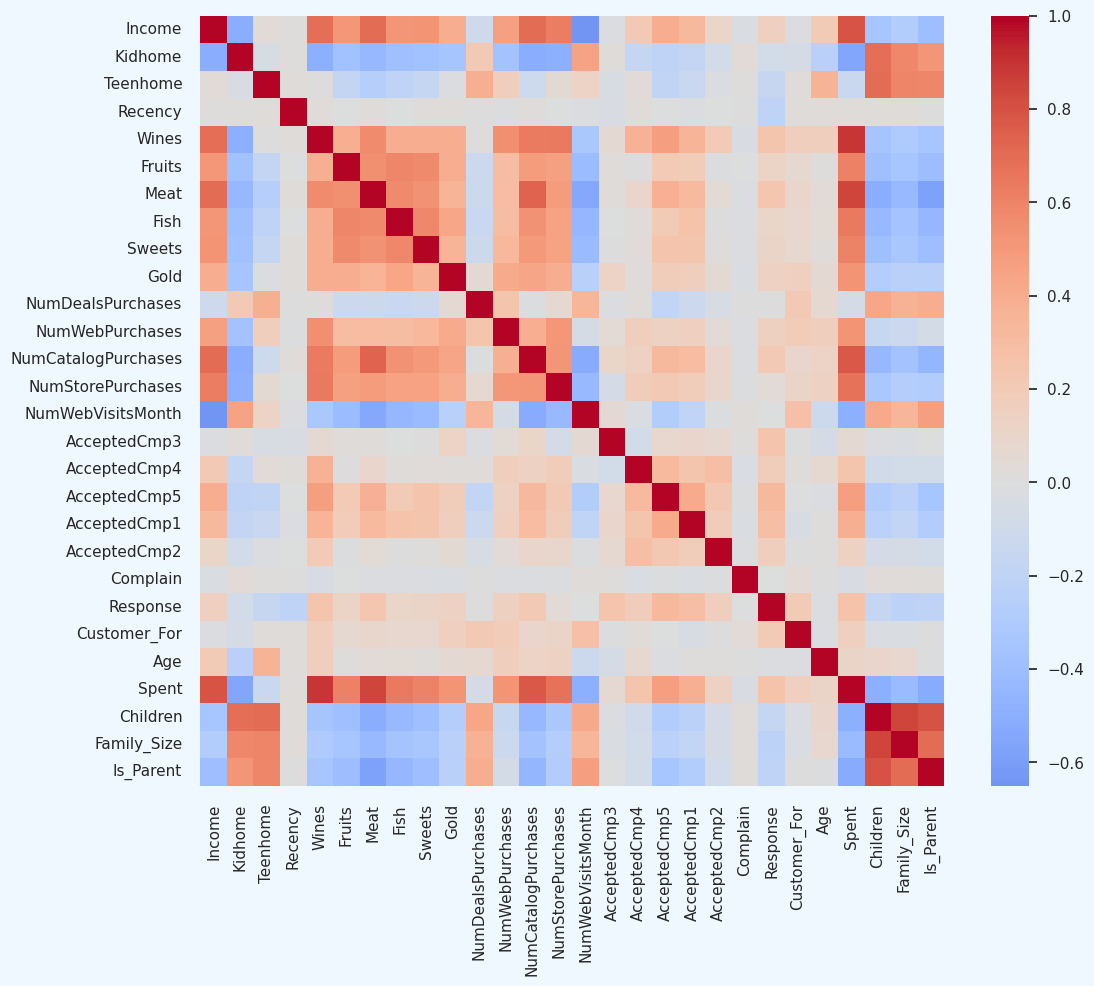

In [ ]:
numeric_data = dataset.select_dtypes(include=[float, int])

# Calculate the correlation matrix for numeric columns
corrmat = numeric_data.corr()

# Select a subset of columns with higher correlations (absolute value > 0.5)
threshold = 0.5
high_corr_columns = corrmat.columns[(corrmat.abs() > threshold).any()]

# Create a reduced correlation matrix
reduced_corrmat = corrmat.loc[high_corr_columns, high_corr_columns]

# Set the colormap
cmap = 'coolwarm'

# Create a smaller, simpler figure and plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(reduced_corrmat, annot=False, cmap=cmap, center=0)

# Show the plot
plt.show()


In [ ]:
# Retrieve the list of categorical variables
categorical_mask = (dataset.dtypes == 'object')
categorical_columns = list(categorical_mask[categorical_mask].index)

print("Categorical variables in the dataset:", categorical_columns)

Categorical variables in the dataset: ['Education', 'Living_With']


In [ ]:
# Perform Label Encoding on the object data types
label_encoder = LabelEncoder()
for column in categorical_columns:
    dataset[column] = dataset[[column]].apply(label_encoder.fit_transform)

print("All features are now numerical")

All features are now numerical


In [ ]:
# Create a copy of the dataset
ds = dataset.copy()

# Create a subset of the DataFrame by dropping specific features related to deals and promotions
columns_to_drop = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(columns=columns_to_drop, axis=1)

# Scaling the data
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds), columns=ds.columns)

print("All features are now scaled")

All features are now scaled


In [ ]:
# Scaled data intended for dimensionality reduction
print("DataFrame that will be used for further modeling:")
scaled_ds.head()

DataFrame that will be used for further modeling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


In [ ]:
# Initiating PCA to reduce dimensions (features) to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=["col1", "col2", "col3"])

# Displaying the summary statistics of the PCA-transformed data
PCA_ds.describe().T


,count,mean,std,min,25%,50%,75%,max
col1,2212.0,7.066881e-17,2.878602,-5.978124,-2.539470,-0.781595,2.386380,7.452915
col2,2212.0,3.212219e-17,1.709469,-4.194757,-1.323929,-0.173721,1.234851,6.168189
col3,2212.0,-1.525804e-17,1.231687,-3.625248,-0.853713,-0.050842,0.863974,6.750458


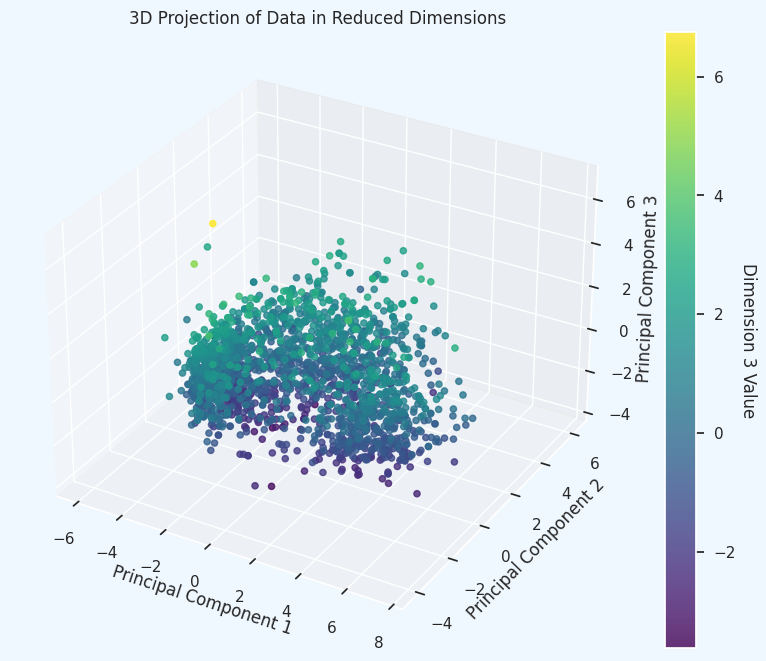

In [ ]:
# Extracting the reduced dimension data for 3D projection
x = PCA_ds["col1"]
y = PCA_ds["col2"]
z = PCA_ds["col3"]

# Creating the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o', alpha=0.8)

# Adding a color bar for better understanding
cbar = fig.colorbar(scatter)
cbar.set_label('Dimension 3 Value', rotation=270, labelpad=15)

# Setting titles and labels
ax.set_title("3D Projection of Data in Reduced Dimensions")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

# Adding grid lines for better readability
ax.grid(True)

plt.show()


Using the Elbow Method to identify the optimal number of clusters:


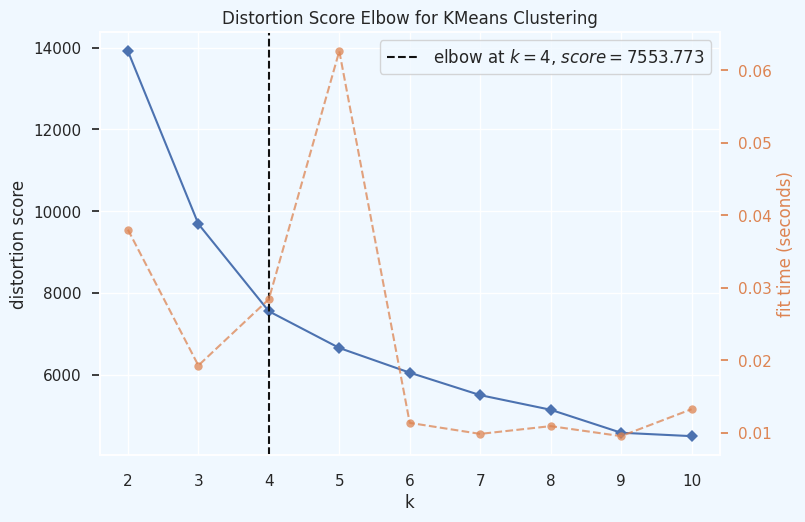

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Using the Elbow Method to identify the optimal number of clusters:')
elbow_visualizer = KElbowVisualizer(KMeans(), k=10)
elbow_visualizer.fit(PCA_ds)
elbow_visualizer.show()

In [ ]:
# Initiating the Agglomerative Clustering model with 4 clusters
agg_clustering = AgglomerativeClustering(n_clusters=4)

# Fit the model and predict cluster labels
cluster_labels = agg_clustering.fit_predict(PCA_ds)

# Adding the cluster labels to the PCA dataset
PCA_ds["Clusters"] = cluster_labels

# Adding the cluster labels to the original dataset
dataset["Clusters"] = cluster_labels


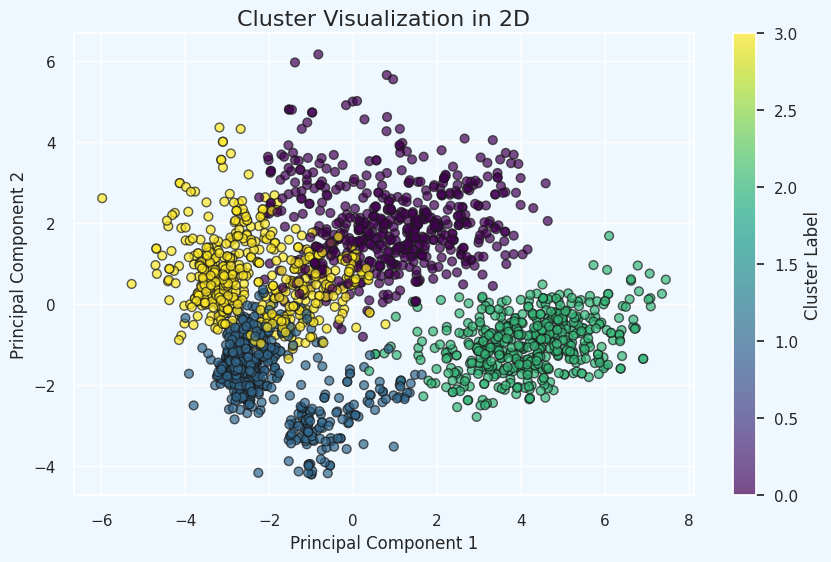

In [ ]:
# Plotting the clusters in 2D for better clarity
plt.figure(figsize=(10, 6))
plt.scatter(PCA_ds["col1"], PCA_ds["col2"], c=PCA_ds["Clusters"], s=40, cmap='viridis', alpha=0.7, edgecolor='k')
plt.title("Cluster Visualization in 2D", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.grid(True)
plt.colorbar(label='Cluster Label')
plt.show()


<ipython-input-35-90ef70ef18de>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  count_plot = sns.countplot(x=dataset["Clusters"], palette=new_palette)


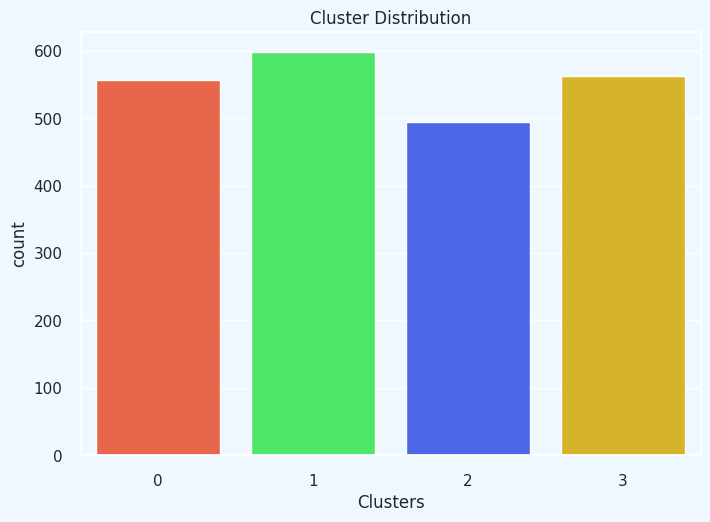

In [ ]:
# Creating a count plot for the clusters with a new color palette
new_palette = ["#FF5733", "#33FF57", "#3357FF", "#F1C40F"]  # New colors
count_plot = sns.countplot(x=dataset["Clusters"], palette=new_palette)
count_plot.set_title("Cluster Distribution")
plt.show()


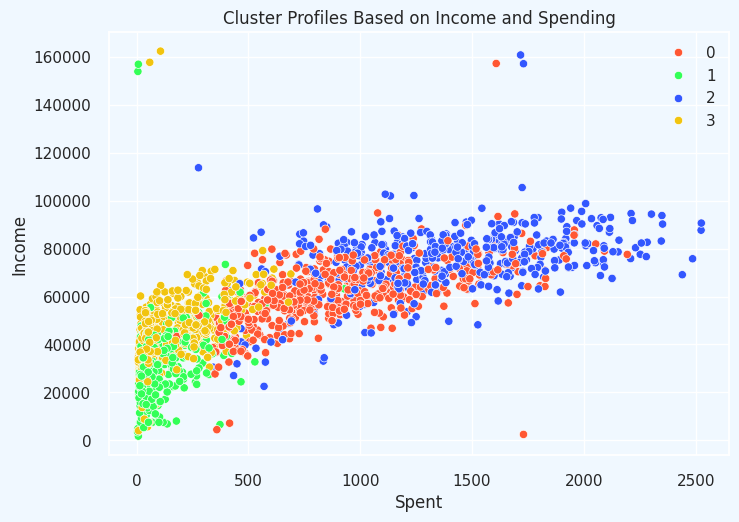

In [ ]:
# Creating a scatter plot to visualize clusters based on income and spending
palette = ["#FF5733", "#33FF57", "#3357FF", "#F1C40F"]  # New colors
scatter_plot = sns.scatterplot(data=dataset, x=dataset["Spent"], y=dataset["Income"], hue=dataset["Clusters"], palette=palette)
scatter_plot.set_title("Cluster Profiles Based on Income and Spending")
plt.legend()
plt.show()


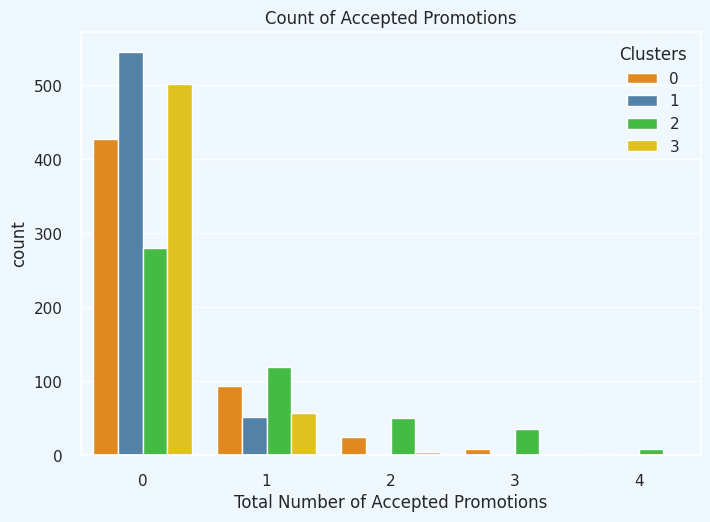

In [ ]:
# Creating a feature to calculate the total number of accepted promotions
dataset["Total_Promos"] = dataset["AcceptedCmp1"] + dataset["AcceptedCmp2"] + dataset["AcceptedCmp3"] + dataset["AcceptedCmp4"] + dataset["AcceptedCmp5"]

# Plotting the count of total promotions accepted
plt.figure()
palette = ["#FF8C00", "#4682B4", "#32CD32", "#FFD700"]  # New colors
count_plot = sns.countplot(x=dataset["Total_Promos"], hue=dataset["Clusters"], palette=palette)
count_plot.set_title("Count of Accepted Promotions")
count_plot.set_xlabel("Total Number of Accepted Promotions")
plt.show()


<ipython-input-38-789b1839d374>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxen_plot = sns.boxenplot(x=dataset["Clusters"], y=dataset["NumDealsPurchases"], palette=palette)


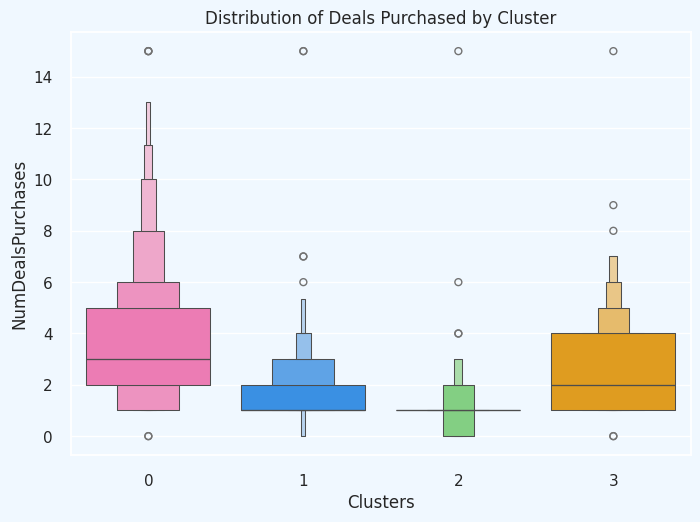

In [ ]:
# Plotting the distribution of the number of deals purchased
plt.figure()
palette = ["#FF69B4", "#1E90FF", "#32CD32", "#FFA500"]  # New colors
boxen_plot = sns.boxenplot(x=dataset["Clusters"], y=dataset["NumDealsPurchases"], palette=palette)
boxen_plot.set_title("Distribution of Deals Purchased by Cluster")
plt.show()


<Figure size 800x550 with 0 Axes>

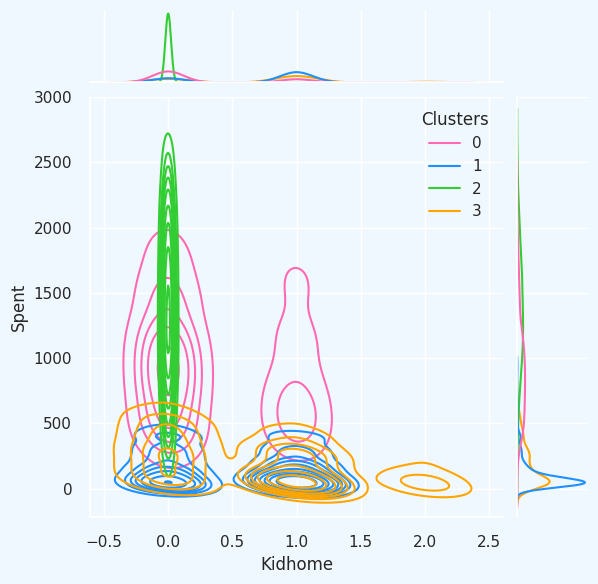

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

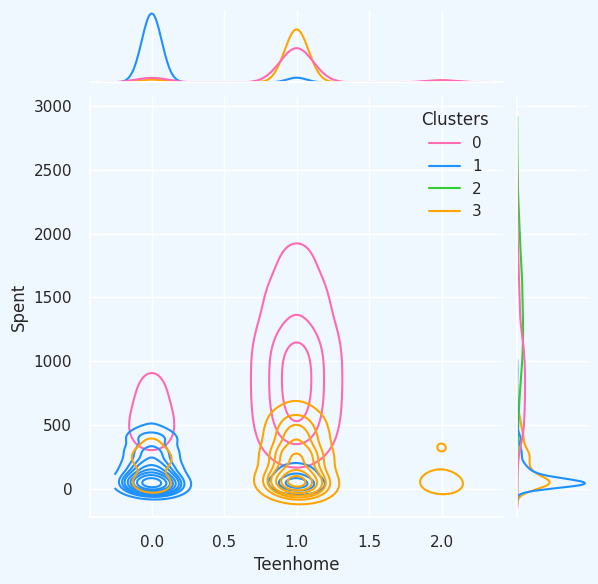

<Figure size 800x550 with 0 Axes>

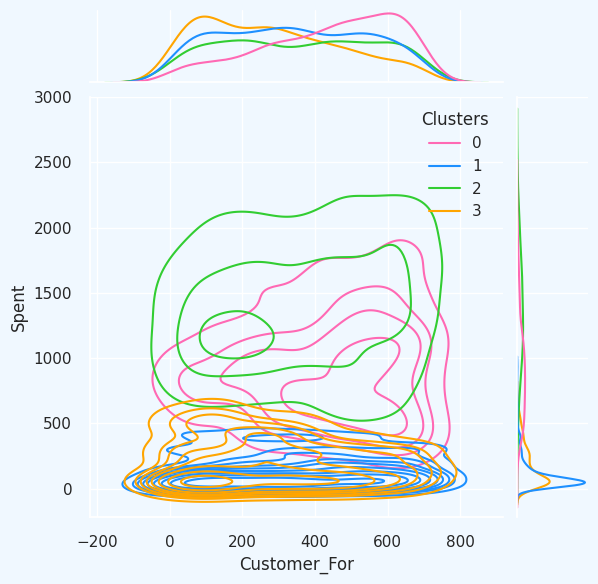

<Figure size 800x550 with 0 Axes>

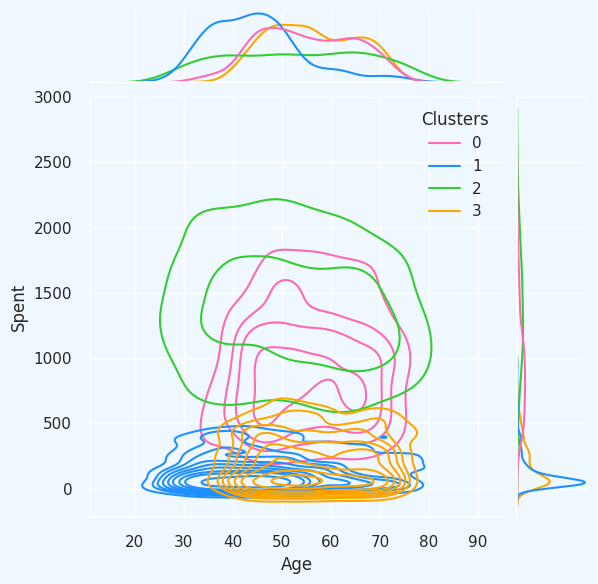

<Figure size 800x550 with 0 Axes>

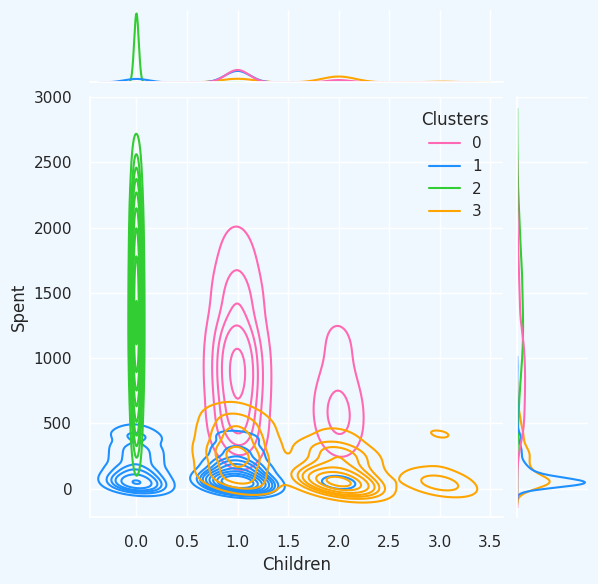

<Figure size 800x550 with 0 Axes>

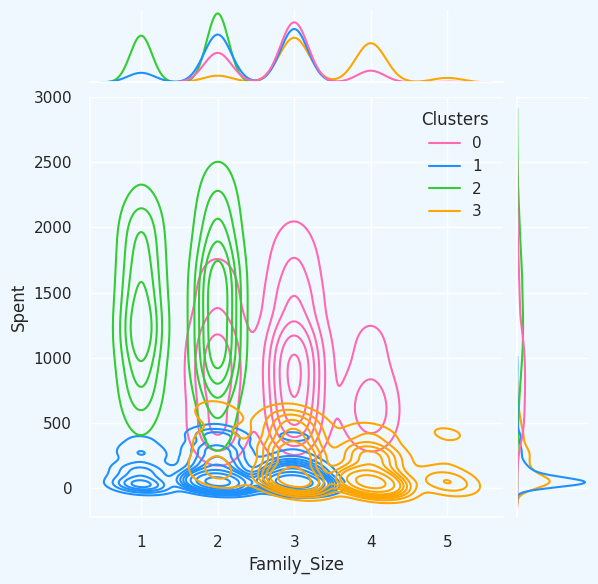

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

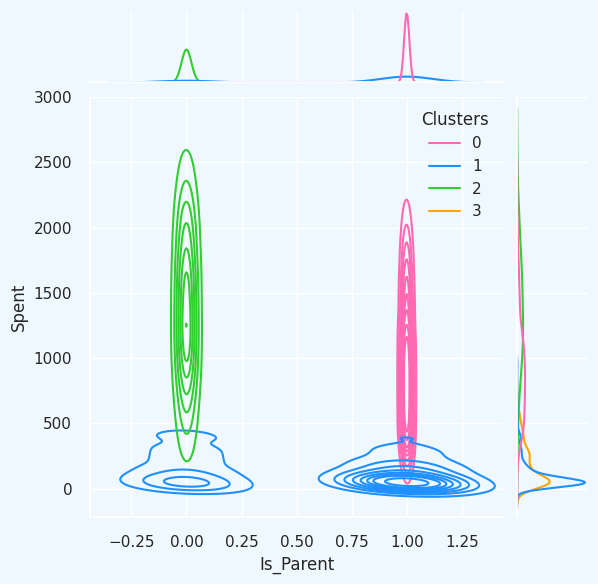

<Figure size 800x550 with 0 Axes>

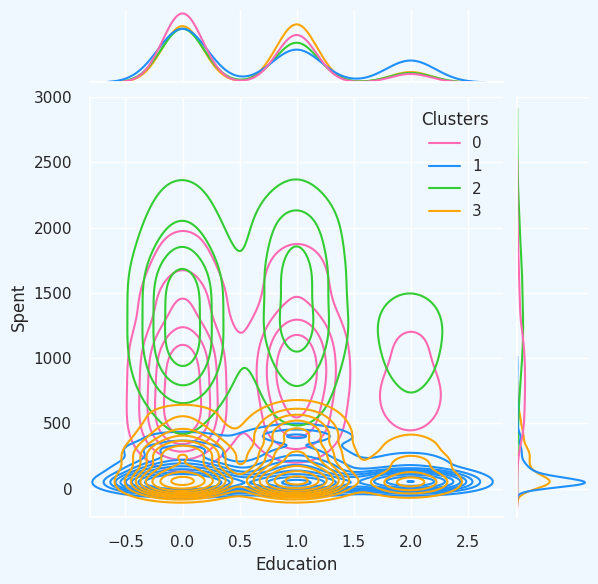

<Figure size 800x550 with 0 Axes>

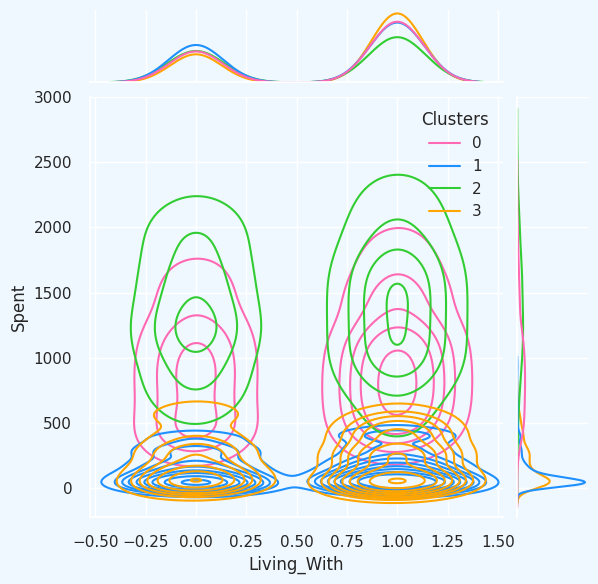

In [ ]:
# Define your color palette
pal = ["#FF69B4", "#1E90FF", "#32CD32", "#FFA500"]  # Example colors

# List of personal features to analyze
personal_features = ["Kidhome", "Teenhome", "Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education", "Living_With"]

# Generating joint plots for each personal feature against spending
for feature in personal_features:
    plt.figure()
    sns.jointplot(x=dataset[feature], y=dataset["Spent"], hue=dataset["Clusters"], kind="kde", palette=pal)
    plt.show()
